In [1]:
# sciencey preamble
%matplotlib inline
import numpy as np
import seaborn
seaborn.set(rc={"figure.figsize": (15, 6)})

def matshow(mat, **kwargs):
    seaborn.heatmap(mat, square=True, xticklabels=50, yticklabels=50, **kwargs)

In [2]:
from conceptnet_retrofitting.loaders import *
from conceptnet_retrofitting.word_vectors import WordVectors
from conceptnet_retrofitting.builders.build_assoc import build_relations_from_conceptnet
from conceptnet_retrofitting.builders.label_set import LabelSet
from conceptnet_retrofitting.builders.retrofit import relational_retrofit
from sklearn.preprocessing import normalize

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/scikit_learn-0.16.1-py3.5-linux-x86_64.egg/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [4]:
PATH = '../build-data/'

In [5]:
labels = LabelSet(load_labels(PATH + 'glove.840B.300d.filtered.conceptnet5.labels'))

In [6]:
sparse_rels = build_relations_from_conceptnet(labels, '/wobbly/data/conceptnet5/assoc/reduced.csv')

In [164]:
glove = load_word_vectors(PATH + 'glove.840B.300d.filtered.conceptnet5.labels', PATH + 'glove.840B.300d.l1.filtered.conceptnet5.npy', PATH + 'wl1-replacements.msgpack')

In [23]:
def infer_orthogonal(A, B):
    aU, aS, aVt = np.linalg.svd(A, full_matrices=False)
    bU, bS, bVt = np.linalg.svd(B, full_matrices=False)
    return aVt.T @ ((aU.T @ bU) @ bVt)

def dense_relation_from_sparse(spmat, dmat):
    dmat2 = np.zeros((spmat.shape[0], dmat.shape[1]))
    dmat2[:dmat.shape[0]] = dmat
    coords = spmat.tocoo()
    left_rows = dmat2[coords.row] * coords.data[:, np.newaxis]
    right_rows = dmat2[coords.col] * coords.data[:, np.newaxis]
    del coords, dmat2
    sqnorms = (left_rows ** 2).sum(1)
    okay_rows = np.flatnonzero(sqnorms)
    return infer_orthogonal(left_rows[okay_rows], right_rows[okay_rows])
    

The dense relational data forms an $11 \times 300 \times 300$ rank-3 array of relations. The first index represents which relation is involved, and the remaining two indices are the 300 GloVe features.



In [9]:
dense_rels = [(print(name) or name, sp, dense_relation_from_sparse(sp, glove.vectors))
              for (name, sp) in sparse_rels.items()
              if name != '/r/RelatedTo'] + [('/r/RelatedTo', sparse_rels['/r/RelatedTo'], np.eye(300))]

/r/CausesDesire
/r/PartOf
/r/IsA
/r/HasSubevent
/r/HasProperty
/r/AtLocation
/r/DerivedFrom
/r/UsedFor
/r/Causes
/r/Antonym


In [10]:
dense_rels.sort(key=lambda item: item[0])

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


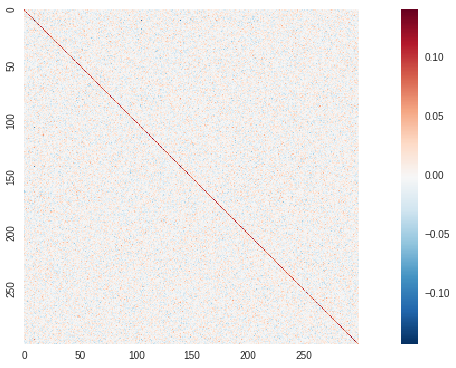

In [11]:
matshow(dense_rels[10][2])

In [12]:
def en_filter(term):
    return term.startswith('/c/en/')

In [13]:
rel_array = np.stack([item[2] for item in dense_rels], axis=0)

In [14]:
rel_array.shape

(11, 300, 300)

In [15]:
rel_labels = [item[0] for item in dense_rels]

In [52]:
def which_relation(wv, rel_array, c1, c2):
    rels = wv.to_vector(c1) @ rel_array @ wv.to_vector(c2)
    return rels

In [138]:
which_relation(glove, np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0), 'pork', 'meat')

array([ 0.32745753,  0.31192527,  0.28551005,  0.07865365,  0.42734648,
        0.3009351 ,  0.21881865,  0.47786543,  0.41078144,  0.8122127 ,
        0.32741096,  0.32769269,  0.2834655 ,  0.30353553,  0.11322767,
        0.42616163,  0.30313439,  0.21164613,  0.39622986,  0.43471644,
        0.8122127 ,  0.30367834])

In [18]:
list(enumerate([rel[0] for rel in dense_rels]))

[(0, '/r/Antonym'),
 (1, '/r/AtLocation'),
 (2, '/r/Causes'),
 (3, '/r/CausesDesire'),
 (4, '/r/DerivedFrom'),
 (5, '/r/HasProperty'),
 (6, '/r/HasSubevent'),
 (7, '/r/IsA'),
 (8, '/r/PartOf'),
 (9, '/r/RelatedTo'),
 (10, '/r/UsedFor')]

In [152]:
def read_analogies(filename):
    for line in open(filename, encoding='utf-8'):
        line = line.rstrip()
        if not line or line.startswith('#'):
            continue
        parts = line.split('\t')
        inputs = parts[1:4]
        answers = parts[4:]
        yield inputs, answers

In [208]:
def analogy(wv, rel_array, c1, c2, c3, num=20):
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)
    rel_labels = [rel[0] for rel in dense_rels] * 2
    
    ratings = np.zeros(wv.vectors.shape[0])
    for ca, cb in ((c2, c3), (c3, c2)):
        rel = which_relation(wv, rar, c1, ca)
        same_rel = np.maximum(0.5, which_relation(wv, rar, cb, cb))
        best_rel = (rel / same_rel)
        # exclude DerivedFrom
        best_rel[4] = 0
        best_rel[15] = 0
        best_rel -= np.min(best_rel)
        best_rel **= 3
        print(list(zip(rel_labels, np.floor(best_rel * 1000))))
        operator = (rar * best_rel[:, np.newaxis, np.newaxis]).sum(0)
        target = wv.to_vector(cb) @ operator
        ratings += wv.vectors @ target
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label) and label != c2 and label != c3:
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found


In [204]:
analogy(glove, rel_array, 'guitar', 'instrument', 'sofa', num=50)

[('/r/Antonym', 4.0), ('/r/AtLocation', 71.0), ('/r/Causes', 61.0), ('/r/CausesDesire', 5.0), ('/r/DerivedFrom', 0.0), ('/r/HasProperty', 11.0), ('/r/HasSubevent', 6.0), ('/r/IsA', 153.0), ('/r/PartOf', 144.0), ('/r/RelatedTo', 232.0), ('/r/UsedFor', 33.0), ('/r/Antonym', 4.0), ('/r/AtLocation', 58.0), ('/r/Causes', 71.0), ('/r/CausesDesire', 6.0), ('/r/DerivedFrom', 0.0), ('/r/HasProperty', 20.0), ('/r/HasSubevent', 12.0), ('/r/IsA', 59.0), ('/r/PartOf', 123.0), ('/r/RelatedTo', 232.0), ('/r/UsedFor', 39.0)]
[('/r/Antonym', 0.0), ('/r/AtLocation', 1.0), ('/r/Causes', 0.0), ('/r/CausesDesire', 0.0), ('/r/DerivedFrom', 0.0), ('/r/HasProperty', 6.0), ('/r/HasSubevent', 2.0), ('/r/IsA', 0.0), ('/r/PartOf', 0.0), ('/r/RelatedTo', 0.0), ('/r/UsedFor', 0.0), ('/r/Antonym', 0.0), ('/r/AtLocation', 1.0), ('/r/Causes', 1.0), ('/r/CausesDesire', 2.0), ('/r/DerivedFrom', 0.0), ('/r/HasProperty', 0.0), ('/r/HasSubevent', 1.0), ('/r/IsA', 1.0), ('/r/PartOf', 0.0), ('/r/RelatedTo', 0.0), ('/r/UsedFo

[('/c/en/sofa', 0.76142556442259701),
 ('/c/en/couch', 0.6760659844760597),
 ('/c/en/loveseat', 0.6490938560358317),
 ('/c/en/recliner', 0.62448500757221992),
 ('/c/en/armchair', 0.60664317204349527),
 ('/c/en/futon', 0.59951991638218083),
 ('/c/en/upholster', 0.59087249045545553),
 ('/c/en/furniture', 0.58960727657818579),
 ('/c/en/livingroom', 0.58387064078629725),
 ('/c/en/chair', 0.5803083785246318),
 ('/c/en/bed', 0.57500949163307036),
 ('/c/en/chaise', 0.55017703524834016),
 ('/c/en/mattress', 0.52877580959000381),
 ('/c/en/headboard', 0.51032706908097991),
 ('/c/en/pillow', 0.5080429661652508),
 ('/c/en/lounger', 0.50634177932856994),
 ('/c/en/bedroom', 0.49772613385209996),
 ('/c/en/comfy', 0.49611839500807559),
 ('/c/en/lounge', 0.49062241941944706),
 ('/c/en/stool', 0.48934284096498804),
 ('/c/en/bunk', 0.48380745725695273),
 ('/c/en/recline', 0.48106667326707597),
 ('/c/en/cushion', 0.47894609158251839),
 ('/c/en/seater', 0.47752436119975122),
 ('/c/en/dresser', 0.4764516402

In [205]:
def eval_analogy(wv, rel_array, c1, c2, c3, c4):
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)
    rating = 0.
    try:
        for ca, cb in ((c2, c3), (c3, c2)):
            rel = which_relation(wv, rar, c1, ca)
            same_rel = np.maximum(0.5, which_relation(wv, rar, cb, cb))
            best_rel = (rel / same_rel)
            best_rel[4] = 0
            best_rel[15] = 0
            best_rel -= np.min(best_rel)
            best_rel **= 3
            operator = (rar * best_rel[:, np.newaxis, np.newaxis]).sum(0)
            target = wv.to_vector(cb) @ operator
            rating += wv.to_vector(c4) @ target
    except KeyError:
        return 0.
    return rating


In [206]:
eval_analogy(glove, rel_array, 'pork', 'meat', 'french', 'language')

1.2954268521247105

In [148]:
def analogy_3cosmul(wv, c1, c2, c3, num=20):
    sims1 = (wv.vectors @ wv.to_vector(c1)) + 1.000001
    sims2 = (wv.vectors @ wv.to_vector(c2)) + 1
    sims3 = (wv.vectors @ wv.to_vector(c3)) + 1
    ratings = sims2 * sims3 / (sims1)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found


In [154]:
def eval_analogy_3cosmul(wv, c1, c2, c3, c4):
    try:
        v4 = wv.to_vector(c4)
        sim1 = v4 @ wv.to_vector(c1) + 1.000001
        sim2 = v4 @ wv.to_vector(c2) + 1
        sim3 = v4 @ wv.to_vector(c3) + 1
    except KeyError:
        return 0.
    return sim2 * sim3 / sim1

In [160]:
def eval_analogies(analogy_func, filename='/nfs/broadway/data/corpora/readtheory-analogies.txt'):
    total = 0
    correct = 0
    for inputs, answers in read_analogies(filename):
        # The 'inputs' are the three given components of the analogy.
        # 'answers' are the multiple-choice answers, where the correct answer is first in the list.
        best_score = 0.
        best_answer = ''
        for answer in answers:
            quad = inputs + [answer]
            score = analogy_func(*quad)
            if score > best_score:
                best_score = score
                best_answer = answer
        total += 1
        if best_answer == answers[0]:
            correct += 1
        else:
            items = tuple(inputs + [best_answer.upper()] + [answers[0].upper()])
            print("%s : %s :: %s : %s (should be %s)" % items)
    print("Score: %2.2f%% (%d/%d)" % (correct / total * 100, correct, total))
    return correct / total

In [157]:
def curry_3cosmul(c1, c2, c3, c4):
    return eval_analogy_3cosmul(glove, c1, c2, c3, c4)

In [158]:
def curry_inferred(c1, c2, c3, c4):
    return eval_analogy(glove, rel_array, c1, c2, c3, c4)

In [213]:
print('\n3cosmul:')
eval_analogies(curry_3cosmul)
print('\ninferred relations:')
eval_analogies(curry_inferred)


3cosmul:
dirt : brown :: leaves : GRAY (should be GREEN)
shoes : feet :: helmet : ARMS (should be HEAD)
banana : yellow :: carrot : RED (should be ORANGE)
now : later :: easy : SIMPLE (should be DIFFICULT)
lettuce : green :: strawberry : ORANGE (should be RED)
fire : hot :: snow : WARM (should be FROZEN)
India : country :: German : NATION (should be LANGUAGE)
Score: 92.39% (85/92)

inferred relations:
shoes : feet :: helmet : ARMS (should be HEAD)
lettuce : green :: strawberry : ORANGE (should be RED)
fire : hot :: snow : WARM (should be FROZEN)
spend : save :: give : ASK (should be RECEIVE)
octagon : eight :: triangle : FOUR (should be THREE)
bow : arrow :: gun : WEAPON (should be BULLET)
Score: 93.48% (86/92)


0.9347826086956522